RECENTLY DONE:
- Connectivity matrices: assign each voxel to Yeo network and assess correlation within-network
    - Re-derive connectomes at parcel-to-parcel level and assess Yeo
- Run statistical tests on current decoding result (AUC difference SRM vs. no SRM across tasks)
- Re-run task decoding with non-denoised images + confounds (cosine and 24 motion regressors)
     - Left rest data (denoised) without confounds

- Tried to figure out and *FAILED* : why does including stop-fail increase AUC so much?

# Current To-Do:
3/19/24: Trial-level beta series instead of raw TR data


Backburner questions:
- DiFuMo atlas instead of Schaefer?
- Different SRM distance penalties (distance as penalty instead of parcelwise? Searchlights instead of parcels?)

# Code snippets for specific purposes

### -- [OLD] Visualizing dropout voxels

In [184]:
import glob
import numpy as np
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain

['missing-0_mask-double', 'missing-0_mask-gm', 'missing-11_mask-double', 'missing-11_mask-gm', 'missing-6_mask-double', 'missing-6_mask-gm']
[144.0, 644.0, 0.0, 0.0, 0.0, 0.0]


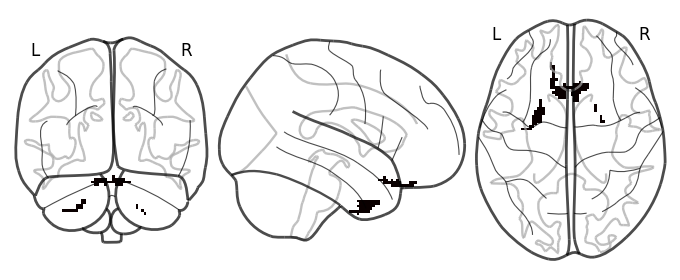

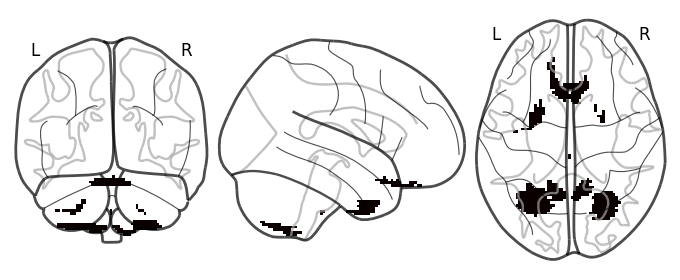

In [191]:
affine = nib.load('data/rest/sub-s03_ses-01_task-rest_run-1_space-MNI_desc-optcomDenoised_bold.nii.gz').affine
fnames = glob.glob('outputs/srm/missing*')
print([f[12:-4] for f in fnames])
files = [np.load(f).astype(float) for f in fnames]
print([np.sum(f) for f in files])
plot_glass_brain(nib.Nifti1Image(files[0], affine))
plot_glass_brain(nib.Nifti1Image(files[1], affine))

In [200]:
resample_target = nib.load('data/rest/sub-s03_ses-01_task-rest_run-1_space-MNI_desc-optcomDenoised_bold.nii.gz')

In [202]:
test = datasets.fetch_atlas_difumo(dimension=512, resolution_mm=2, data_dir='data/templates')

atlas_resampled = resample_img(test.maps, 
                                    target_shape = resample_target.shape[:3],
                                    target_affine = resample_target.affine,
                                    interpolation = 'nearest')

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\datasets\atlas.py:142: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


### -- [OLD] Figuring out faulty connectome issue

In [55]:
from connectivity import get_parcellation, load_data_one_session, compute_fc_one_session
import glob
import numpy as np
import nibabel as nib
from math import tanh
from nilearn.maskers import NiftiLabelsMasker, MultiNiftiLabelsMasker
from nilearn.image import math_img
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome import ConnectivityMeasure
import pandas as pd

In [56]:
idx = np.array([3,6,7,9,10,11,12]) - 1 # affected sessions
files, confounds_files = (glob.glob('data/rest/*'), glob.glob('data/confounds/*'))
parcel_labels, parcel_map, parcel_mask = get_parcellation(atlas = 'schaefer', n_dimensions = 400, resample_target = nib.load(files[0])) 
gm_mask = math_img('img >= 0.5', img=nib.load('data/templates/tpl-MNI152NLin2009cAsym_res-02_label-GM_probseg.nii.gz'))
combined_mask = math_img('img1 * img2', img1=gm_mask, img2=parcel_mask)
parcel_masker = MultiNiftiLabelsMasker(
    mask_img = combined_mask,
    labels_img = parcel_map,
    labels = parcel_labels,
    standardize = 'zscore_sample',
    n_jobs=2
)
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    vectorize = True # flatten 
)

In [58]:
parcel_data = parcel_masker.fit_transform(files, confounds = confounds_files)
connectomes = np.array(correlation_measure.fit_transform(parcel_data))
corrs = np.corrcoef(connectomes)

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

In [59]:
parcel_data2 = parcel_masker.fit_transform(files)
connectomes2 = np.array(correlation_measure.fit_transform(parcel_data2))
corrs2 = np.corrcoef(connectomes2)

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

In [145]:
confounds_include = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 'csf', 'white_matter']
confounds_files = glob.glob('data/confounds/*sub*')
new_confounds_files = [pd.read_csv(i, sep='\t')[confounds_include] for i in confounds_files]

parcel_data3 = parcel_masker.fit_transform(files, confounds=new_confounds_files)
connectomes3 = np.array(correlation_measure.fit_transform(parcel_data3))
corrs3 = np.corrcoef(connectomes3)

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

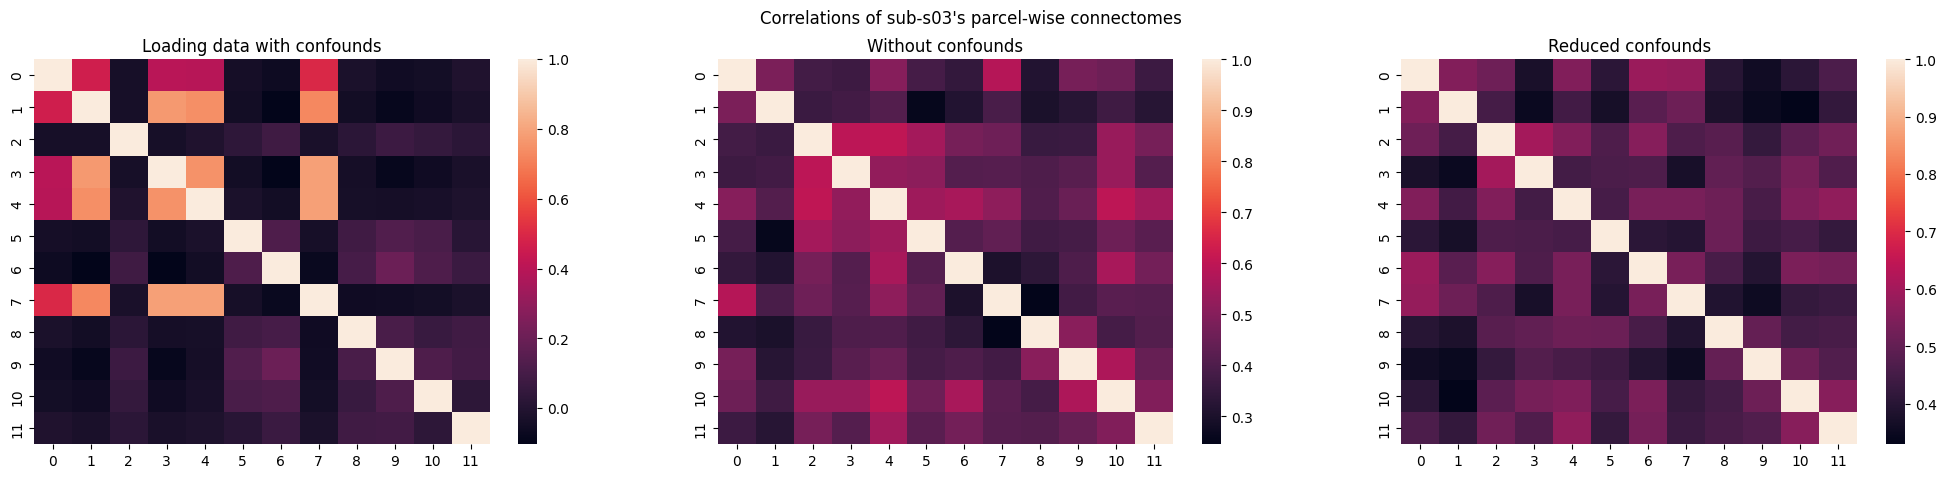

In [146]:
fig, ax = plt.subplots(1, 3, figsize=(25,5))
fig.suptitle('Correlations of sub-s03\'s parcel-wise connectomes')
ax[0].set_title('Loading data with confounds')
sns.heatmap(corrs, ax=ax[0])
ax[1].set_title('Without confounds')
sns.heatmap(corrs2, ax=ax[1])
ax[2].set_title('Reduced confounds')
sns.heatmap(corrs3, ax=ax[2])
plt.show()

In [150]:
test = pd.read_csv(confounds_files[0], sep='\t')
confounds_exclude = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement', 
    'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 'csf', 'white_matter']

[i for i in test if i not in confounds_exclude]

['Unnamed: 0',
 'global_signal',
 'global_signal_derivative1',
 'global_signal_derivative1_power2',
 'global_signal_power2',
 'csf_derivative1',
 'csf_derivative1_power2',
 'csf_power2',
 'white_matter_derivative1',
 'white_matter_power2',
 'white_matter_derivative1_power2',
 'csf_wm',
 'tcompcor',
 'std_dvars',
 'dvars',
 'rmsd',
 't_comp_cor_00',
 'c_comp_cor_00',
 'c_comp_cor_01',
 'c_comp_cor_02',
 'c_comp_cor_03',
 'c_comp_cor_04',
 'c_comp_cor_05',
 'w_comp_cor_00',
 'w_comp_cor_01',
 'w_comp_cor_02',
 'w_comp_cor_03',
 'w_comp_cor_04',
 'w_comp_cor_05',
 'w_comp_cor_06',
 'w_comp_cor_07',
 'w_comp_cor_08',
 'w_comp_cor_09',
 'w_comp_cor_10',
 'w_comp_cor_11',
 'w_comp_cor_12',
 'w_comp_cor_13',
 'w_comp_cor_14',
 'w_comp_cor_15',
 'w_comp_cor_16',
 'w_comp_cor_17',
 'w_comp_cor_18',
 'w_comp_cor_19',
 'w_comp_cor_20',
 'w_comp_cor_21',
 'w_comp_cor_22',
 'w_comp_cor_23',
 'w_comp_cor_24',
 'w_comp_cor_25',
 'w_comp_cor_26',
 'w_comp_cor_27',
 'w_comp_cor_28',
 'w_comp_cor_29',
 

In [ ]:
def load_plot(confounds_include):
    confounds_include = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 'csf', 'white_matter']
    
    confounds_files = glob.glob('data/confounds/*sub*')
    new_confounds_files = [pd.read_csv(i, sep='\t')[confounds_include] for i in confounds_files]

    parcel_data = parcel_masker.fit_transform(files, confounds=new_confounds_files)
    connectomes = np.array(correlation_measure.fit_transform(parcel_data))
    corrs = np.corrcoef(connectomes)

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    fig.suptitle(f'Confounds included: \'{confounds_include}\'')
    sns.heatmap(corrs, ax=ax)
    plt.show()

test_exclude = ['global','csf','trans','rot','white_matter','comp','non_steady','motion_outlier']
for k in range(len(test_exclude)):
    load_plot(test_exclude[k])


c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

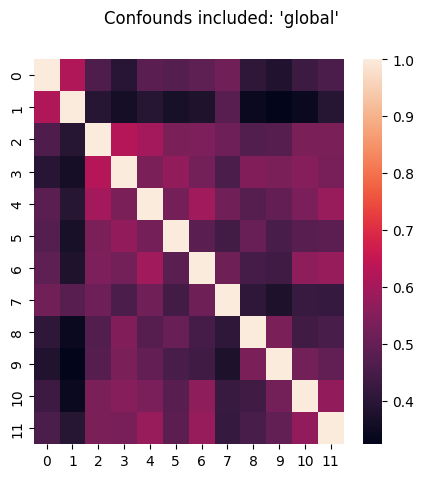

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

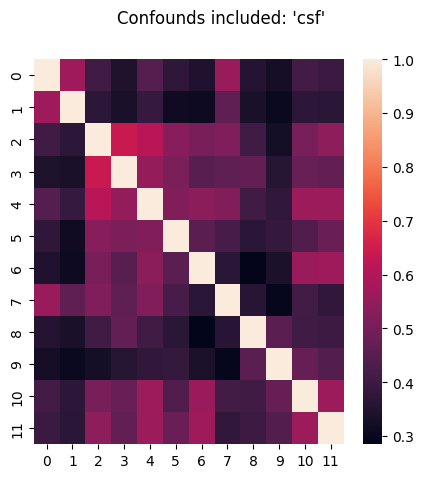

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

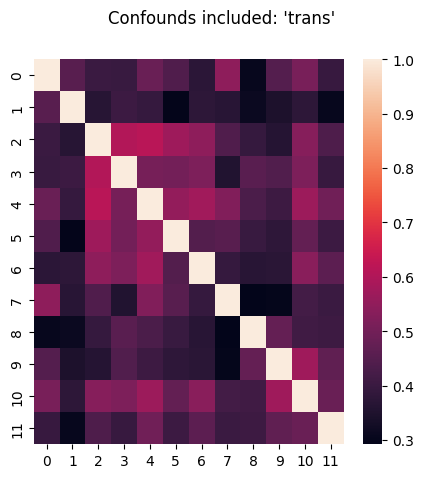

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

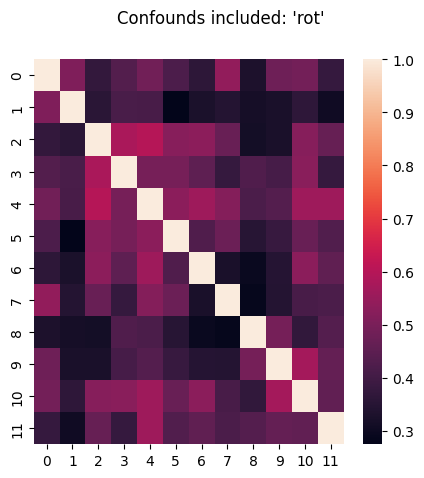

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

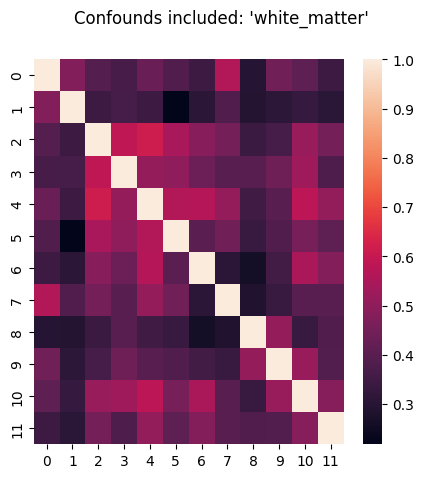

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

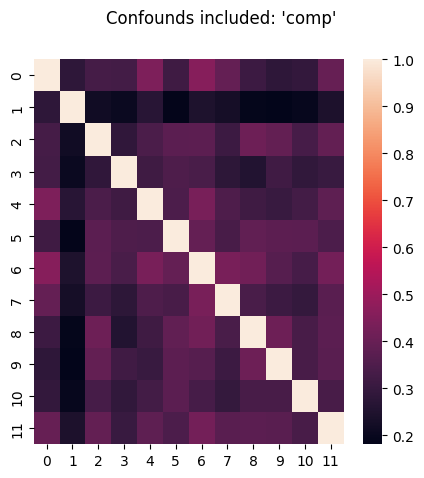

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

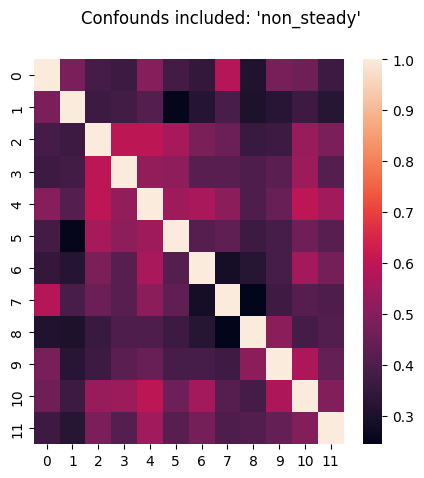

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\nilearn\connectome\connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
c:\U

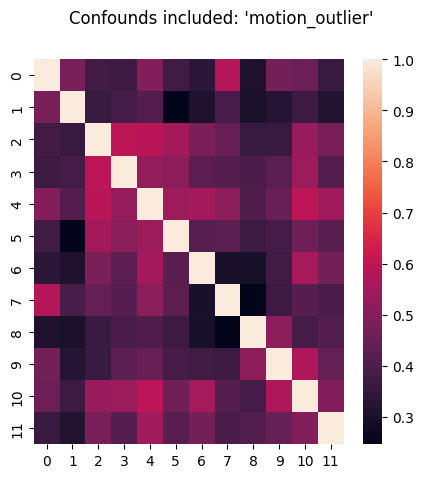

In [130]:
def load_plot(confounds_include):

    confounds_files = glob.glob('data/confounds/*sub*')
    new_confounds_files = []

    for i in range(len(confounds_files)):
        confounds = pd.read_csv(confounds_files[i], sep='\t')
        confounds[[j for j in confounds.columns if confounds_include in j]].to_csv(f'data/confounds/testing/{i}.tsv', sep='\t')
        new_confounds_files.append(f'data/confounds/testing/{i}.tsv')

    parcel_data = parcel_masker.fit_transform(files, confounds = new_confounds_files)
    connectomes = np.array(correlation_measure.fit_transform(parcel_data))
    corrs = np.corrcoef(connectomes)

    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    fig.suptitle(f'Confounds included: \'{confounds_include}\'')
    sns.heatmap(corrs, ax=ax)
    plt.show()

test_exclude = ['global','csf','trans','rot','white_matter','comp','non_steady','motion_outlier']
for k in range(len(test_exclude)):
    load_plot(test_exclude[k])


### -- Assess within-network correlation of connectomes


Organize subject-averaged connectomes (used to derive SRM) by Yeo networks and assess off-diagonal structure.

In [1]:
from nilearn import datasets
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 1. load map of network labels to label each voxel in the connectomes
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir='data/templates', verbose=0)
atlas.labels = np.insert(atlas.labels, 0, "Background") # for proper indexing, insert a 0

def get_side_and_network(b):
    arr = b.astype(str).split('_')
    if len(arr) > 3:
        return arr[1] + '_' + arr[2]
    return 'background'

network_labels = [get_side_and_network(l) for l in atlas.labels]
parcel_map = np.load('outputs/parcel_map_flat.npy').astype(int) # voxel map of parcel indices that was masked/flattened to match our connectomes
network_label_map = [network_labels[i] for i in parcel_map] # extract network label of each voxel

# 2. load data
sub_list = np.unique([f[f.find('sub'):f.find('sub')+7] for f in glob.glob('outputs/connectomes/*avg*')])
data_list = [np.load(glob.glob(f'outputs/connectomes/{sub}_connectome_avg.npy')[0]) for sub in sub_list]

In [ ]:
# assessment 1: for each voxel, get average within-network correlation and average across-network correlation
within_network = []
across_network = []

for d in data_list:
    for i in range(d.shape[0]):
        voxel_network_label = network_label_map[i]
        voxel_within = []
        voxel_across = []
        for j in range(d.shape[1]):
            parcel_network_label = network_labels[j+1] # labels are 1-indexed
            if voxel_network_label == parcel_network_label:
                voxel_within.append(d[i,j])
            else:
                voxel_across.append(d[i,j])
        within_network.append(np.mean(voxel_within))
        across_network.append(np.mean(voxel_across))


fig, ax = plt.subplots(1,1, figsize=(5,5))
fig.suptitle('Comparing voxel-to-parcel correlelations within vs. across 7 Yeo networks')
ax.bar(x=0, height=np.mean(within_network), width=0.4, yerr=np.std(within_network), capsize=5)
ax.bar(x=1, height=np.mean(across_network), width=0.4, yerr=np.std(across_network), capsize=5)
ax.set_ylabel('Average correlation')
ax.set_ylim(0,1)
ax.set_xticks([0,1])
ax.set_xticklabels(['Within-network', 'Across-network'])
plt.show()


In [ ]:
# assessment 2: average all voxels within a parcel, sort parcel-rows by network label, plot in heatmap
# average voxels within a parcel in the connectome
data_parcel = []
for d in data_list:
    parcel_connectome = np.zeros((400,400))
    for p in np.unique(parcel_map):
        p_rows = np.where(parcel_map == p)[0]
        parcel_connectome[p-1] = np.mean(d[p_rows], axis = 0)
    data_parcel.append(parcel_connectome)

# sort parcels by Yeo network membership
network_labels_minus_background = network_labels[1:] # 400 entries, matching each parcel
network_order = ['LH_Cont', 'RH_Cont', 'LH_Default', 'RH_Default', 'LH_DorsAttn', 'RH_DorsAttn', 'LH_Limbic', 'RH_Limbic', 
                 'LH_SalVentAttn', 'RH_SalVentAttn', 'LH_SomMot', 'LH_Vis', 'RH_Vis', 'RH_SomMot']
network_order_indexed = {label: i for i, label in enumerate(network_order)} # convert to dict for next line
network_sorted_parcel_idxs =  sorted(range(len(network_labels_minus_background)), key=lambda x: network_order_indexed[network_labels_minus_background[x]]) # sort parcelwise network label list & save index order

data_parcel_sorted = [d[network_sorted_parcel_idxs] for d in data_parcel]


# plot
n_subs = len(sub_list)
ticks = []
last = ''
for i in range(400): 
    if network_labels_minus_background[network_sorted_parcel_idxs[i]] != last:
        ticks.append(i)
    last = network_labels_minus_background[network_sorted_parcel_idxs[i]]

fig, axs = plt.subplots(n_subs, 1, figsize=(7, 7*n_subs))
fig.suptitle('Subject-specific voxel-level connectomes grouped by Yeo network identity')
for i, ax in enumerate(axs):
    sns.heatmap(data_parcel_sorted[i], ax=ax)
    ax.set_title(sub_list[i])
    ax.set_xticks(ticks)
    ax.set_xticklabels(network_order, rotation=90)
    ax.set_yticks(ticks)
    ax.set_yticklabels(network_order)

plt.show()
# plt.savefig('outputs/connectomes/connectome_network_plot')
# plt.savefig('outputs/new_results/connectome_network_plot')

In [ ]:
# assessment 3: visualize parcel-to-parcel connectomes (run separately on sherlock)

# import pandas as pd
# import nibabel as nib
# import numpy as np
# from nilearn.maskers import MultiNiftiLabelsMasker
# from nilearn.connectome import ConnectivityMeasure
# from connectivity import get_rest_filenames, get_parcellation, get_combined_mask
# files, confound_files = get_rest_filenames()
# subject_session_list = [(f[f.find('sub'):f.find('sub')+7], f[f.find('ses'):f.find('ses')+6]) for f in files]
# sub_list = np.unique([f[f.find('sub'):f.find('sub')+7] for f in files])
# parcel_labels, parcel_map, _ = get_parcellation(atlas = 'schaefer', n_dimensions = 400, resample_target = nib.load(files[0]))
# def get_confounds_df(confound_file):
#     cols = ['csf', 'white_matter', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
#     return pd.read_csv(confound_file, sep='\t')[cols]
# def load_subject_data(sub, files, confound_files, parcel_labels, parcel_map):
#     print('starting subject ' + sub)
#     parcel_masker = MultiNiftiLabelsMasker(
#         mask_img = get_combined_mask(),
#         labels_img = parcel_map,
#         labels = parcel_labels,
#         standardize = 'zscore_sample',
#         n_jobs = 32
#     )
#     files = [f for f in files if sub in f]
#     confounds_dfs = [get_confounds_df(f) for f in confound_files if sub in f]
#     return parcel_masker.fit_transform(files, confounds=confounds_dfs)
# def get_average_fc(subject_data):
#     correlation_measure = ConnectivityMeasure(kind="correlation")
#     subject_fcs = correlation_measure.fit_transform(subject_data)
#     return np.mean(subject_fcs, axis=0)
# subject_average_fcs = [get_average_fc( load_subject_data(sub, files, confound_files, parcel_labels, parcel_map) ) for sub in sub_list]

import numpy as np
from nilearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

connectomes = np.load('outputs/connectomes/subject_average_fcs.npy') # 5 matrices of shape (400,400)

# get network labels and sort connectomes
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir='data/templates', verbose=0)

def get_side_and_network(b):
    arr = b.astype(str).split('_')
    return arr[1] + '_' + arr[2]

network_labels = [get_side_and_network(l) for l in atlas.labels]
network_order = ['LH_Cont', 'RH_Cont', 'LH_Default', 'RH_Default', 'LH_DorsAttn', 'RH_DorsAttn', 'LH_Limbic', 'RH_Limbic', 
                 'LH_SalVentAttn', 'RH_SalVentAttn', 'LH_SomMot', 'LH_Vis', 'RH_Vis', 'RH_SomMot']
network_order_indexed = {label: i for i, label in enumerate(network_order)} # convert to dict for sorting
sorted_parcel_idxs =  sorted(range(len(network_labels)), key=lambda x: network_order_indexed[network_labels[x]]) # sort parcelwise network label list & save index order
network_labels_sorted = np.array(network_labels)[sorted_parcel_idxs]

connectomes_sorted = [c[sorted_parcel_idxs] for c in connectomes]

# plot in sorted order
n_subs = len(connectomes)
ticks = []
last = ''
for i in range(400): 
    if network_labels[sorted_parcel_idxs[i]] != last:
        ticks.append(i)
    last = network_labels[sorted_parcel_idxs[i]]

fig, axs = plt.subplots(n_subs, 1, figsize=(7, 7*n_subs))
fig.suptitle('Subject-specific parcel-level connectomes grouped by Yeo network identity')
for i, ax in enumerate(axs):
    sns.heatmap(connectomes_sorted[i], ax=ax)
    ax.set_title(sub_list[i])
    ax.set_xticks(ticks)
    ax.set_xticklabels(network_order, rotation=90)
    ax.set_yticks(ticks)
    ax.set_yticklabels(network_order)
plt.show()
plt.savefig('outputs/connectomes/parceltoparcel_connectome_network_plot')
plt.savefig('outputs/new_results/parceltoparcel_connectome_network_plot')

### -- Save SRM-transformed task data on sherlock

In [ ]:
## Code 
from task_decoding import load_data, label_trs, srm_transform

tasks = ['goNogo','shapeMatching','spatialTS','cuedTS','flanker','nBack','stopSignal', 'directedForgetting']
for task in tasks:
    print(f'starting {task}')
    data, events, subjects = load_data(task)
    print(f'loaded data for {task}')

    # nas = na_check(data, subjects)
    # data, labels = average_trials(data, events)
    data, labels = label_trs(data, events)
    print(f'labeled {task}')

    data_srm = srm_transform(data, subjects)
    print(f'srm\'d  {task}')

    np.savez(f'/scratch/users/csiyer/decoding_outputs/srm_data_{task}.npz', *data_srm)
    np.savez(f'/scratch/users/csiyer/decoding_outputs/labels_{task}.npz', *labels)
    np.save(f'/scratch/users/csiyer/decoding_outputs/subjects_{task}.npz', subjects)

"""
Reading data back out:

load = np.load(f'/scratch/users/csiyer/decoding_outputs/srm_data_{task}.npz')
data_srm = [load[k] for k in load]
load = np.load(f'/scratch/users/csiyer/decoding_outputs/labels_{task}.npz')
labels = [load[k] for k in load]
subjects = np.load(f'/scratch/users/csiyer/decoding_outputs/subjects_{task}.npz')
"""

### -- Save file with task conditions to decode

In [196]:
# specify what we are decoding, use this to filter & label just these trials
task_conditions = {
    'goNogo': {
        'colname': 'correct_response',
        'values': {
            -1: 'no-go',
            71: 'go',
            89: 'go'
        }
    },
    'stopSignal': {
        'colname': 'trial_type',
        'values': {
            'go': 'go',
            'stop_failure': 'stop_failure',
            'stop_success': 'stop_success'
        }
    },
    'flanker': {
        'colname': 'trial_type',
        'values': {
            'congruent': 'congruent',
            'incongruent': 'incongruent'
        }
    },
    'cuedTS': {
        'colname': 'trial_type',
        'values' : {
            'tstay_cstay': 'tstay_cstay', 
            'tswitch_cswitch': 'tswitch_cswitch', 
            'tstay_cswitch': 'tstay_cswitch'
        }
    },
    'spatialTS': {
        'colname': 'trial_type',
        'values' : {
            'tstay_cstay': 'tstay_cstay', 
            'tswitch_cswitch': 'tswitch_cswitch', 
            'tstay_cswitch': 'tstay_cswitch'
        }
    },
    'nBack': {
        'colname': 'delay',
        'values': {
            1: '1-back',
            2: '2-back'
        }
    },
    'directedForgetting': {
        'colname': 'trial_type',
        'values': {
            'pos': 'pos',
            'neg': 'neg',
            'con': 'con'
        }
    },
    'shapeMatching': {
        'colname': 'trial_type',
        'values': { # PREVIOUSLY: decoded all 7 types. here, group into whether distractor is congruent with match/mismatch conclusion
            'SSS': 'congruent', # 'SSS',
            'DDD': 'congruent', # 'DDD'
            'DDS': 'incongruent', # 'DDS',
            'SDD': 'incongruent', # 'DDD',
            'DSD': 'incongruent', # 'DSD',
            'DNN': 'neutral', # 'DNN',
            'SNN': 'neutral' # 'SNN'
        }
    },
}

with open('utils/task_decoding_conditions.json', 'w') as file:
    file.write(str(task_conditions))

### -- Visualize confusion matrices

In [265]:
def aggregate_cms(task_cms):
    return np.sum(task_cms, axis=0) / np.sum(task_cms) 

i=0
task = 'stopSignal'

with open('outputs/decoding/alltrials.pkl', 'rb') as file:
    results = pickle.load(file)
file.close()

with open('utils/task_decoding_conditions.json', 'r') as file:
    task_conditions = eval(file.read())
file.close()

cm_srm = aggregate_cms(results['cms_srm'][i])
cm_nosrm = aggregate_cms(results['cms_nosrm'][i])

labels = sorted( np.unique([i for i in task_conditions[task]['values'].values()]) ) # sorted() should give same label order as the confusion_matrix fxn
if task == 'stopSignal' and cm_srm.shape[0] < 3:
    labels = ['go', 'stop_success']
print(labels)


['go', 'stop_failure', 'stop_success']


In [266]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def aggregate_cms(task_cms):
    return np.sum(task_cms, axis=0) / np.sum(task_cms) 

def visualize_cms(fname, show = True, save = False, tasks = ['stopSignal','nBack','directedForgetting','goNogo','shapeMatching','spatialTS','cuedTS','flanker']):
    ############ IMPORTANT: CHANGE THE ORDERING OF TASKS WHEN I CHANGE IT IN TASK DECODING SCRIPT ############
    with open(fname, 'rb') as file:
        results = pickle.load(file)
    file.close()
    with open('utils/task_decoding_conditions.json', 'r') as file:
        task_conditions = eval(file.read())
    file.close()

    for i,task in enumerate(tasks):
        cm_srm = aggregate_cms(results['cms_srm'][i])
        cm_nosrm = aggregate_cms(results['cms_nosrm'][i])

        labels = sorted( np.unique([i for i in task_conditions[task]['values'].values()]) ) # sorted() should give same label order as the confusion_matrix fxn
        if task == 'stopSignal' and cm_srm.shape[0] < 3:
            # for correct-only, we have to exclude stop failure from the normal conditions
            labels = ['go', 'stop_success']

        fig, ax = plt.subplots(1,2, figsize=(9, 4.5))
        fig.suptitle(f'Confusion matrix, {task}')

        sns.heatmap(cm_srm, annot=True, cmap='Blues', cbar=False, square=True,
            xticklabels=labels, yticklabels=labels, ax=ax[0], label = 'SRM-transformed')
        ax[0].set_xlabel('Predicted label')
        ax[0].set_ylabel('True label')
        ax[0].set_title('SRM-transformed')
        sns.heatmap(cm_nosrm, annot=True, cmap='Blues', cbar=False, square=True,
            xticklabels=labels, yticklabels=labels, ax=ax[1], label = 'MNI only')
        ax[1].set_xlabel('Predicted label')
        ax[1].set_ylabel('True label')
        ax[1].set_title('MNI only')
    
        if show:
            plt.show()

    if save:
        all_figures = plt.get_fignums()
        with PdfPages(fname[:-4] + '_cms.pdf') as pdf:
            for i, fig_num in enumerate(all_figures):
                plt.figure(fig_num)
                pdf.savefig()
                plt.close()

# save_plots(infile = 'outputs/decoding/alltrials.pkl', outfile = 'outputs/decoding/alltrials_cms.pdf', show = True)
# save_plots(infile = 'outputs/decoding/correctonly.pkl', outfile = 'outputs/decoding/correctonly_cms.pdf', show = True)

visualize_cms(fname  = 'outputs/decoding/alltrials.pkl', save = True, show=False)
visualize_cms(fname  = 'outputs/decoding/correctonly.pkl', save = True, show=False)

### -- Statistical tests on decoding results

In [255]:
import numpy as np
import pickle
import pandas as pd
import statsmodels.formula.api as smf

In [256]:
def aggregate_cms(task_cms):
    return np.sum(task_cms, axis=0) / np.sum(task_cms) 

with open('outputs/decoding/correctonly.pkl', 'rb') as file:
    results = pickle.load(file)
file.close()

with open('utils/task_decoding_conditions.json', 'r') as file:
    task_conditions = eval(file.read())
file.close()

cm_srm = [aggregate_cms(task_cms) for task_cms in results['cms_srm']]
cm_nosrm = [aggregate_cms(task_cms) for task_cms in results['cms_nosrm']]
task_order = ['stopSignal','nBack','directedForgetting','goNogo','shapeMatching','spatialTS','cuedTS','flanker']

In [264]:
data = {'method': [], 'task': [], 'auc': []}
for i, (aucs_srm, aucs_nosrm) in enumerate(zip(results['aucs_srm'], results['aucs_nosrm'])):
    for a in aucs_srm:
        data['method'].append('srm')
        data['task'].append(i)
        data['auc'].append(a)
    for a in aucs_nosrm:
        data['method'].append('no_srm')
        data['task'].append(i)
        data['auc'].append(a)

df = pd.DataFrame(data)
df['task'] = df['task'].astype('category')
md = smf.mixedlm("auc ~ method", df, groups=df["task"], re_formula="~method")
mdf = md.fit()
print(mdf.summary())


# 2. t-tests
from scipy.stats import ttest_rel
print('Follow-up t-tests:')
print('All data points, paired (ignore): ', ttest_rel(np.array(results['aucs_srm']).flatten(), np.array(results['aucs_nosrm']).flatten())) # observations not independent b/c from same CV fold
print('Averaged within task (across folds): ', ttest_rel(np.mean(results['aucs_srm'], axis=1), np.mean(results['aucs_nosrm'], axis=1))) # average within task

               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     auc     
No. Observations:       80          Method:                 REML    
No. Groups:             8           Scale:                  0.0004  
Min. group size:        10          Log-Likelihood:         172.6246
Max. group size:        10          Converged:              Yes     
Mean group size:        10.0                                        
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.513    0.019 27.592 0.000  0.477  0.550
method[T.srm]              0.019    0.007  2.551 0.011  0.004  0.034
Group Var                  0.003    0.075                           
Group x method[T.srm] Cov -0.001    0.026                           
method[T.srm] Var          0.000    0.012         

c:\Users\ciyer\miniconda3\envs\lab\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Testing

In [ ]:
from task_decoding import load_data, srm_transform, label_trs, loso_cv

task = 'stopSignal'
data, events, subjects = load_data(task)
data, labels = label_trs(data, events, task, correct_only=False) 
data_srm = srm_transform(data, subjects)
task_aucs_srm, task_cms_srm = loso_cv(data_srm, labels, subjects)

print(task_aucs_srm)

In [ ]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score, confusion_matrix
from joblib import Parallel, delayed

def concatenate_data_labels(idxs, data): 
    n_features = data[0].shape[1] 
    n_trials_total = sum([d.shape[0] for k,d in enumerate(data) if k in idxs]) 
    train_data = np.zeros((n_trials_total, n_features)) 
    train_labels = np.array([])
    start_index = 0 # initialize
    for idx in idxs:
        n_trials = data[idx].shape[0]
        end_index = start_index + n_trials
        train_data[start_index:end_index,:] = data[idx]
        train_labels = np.append(train_labels, labels[idx])
        start_index += n_trials
    return train_data, train_labels 

# def predict_left_out_subject(sub, data):

sub = subjects[3]
sub_indices = [j for j,s in enumerate(subjects) if s == sub]
loso_indices = [j for j,s in enumerate(subjects) if s != sub] 
train_data, train_labels = concatenate_data_labels(loso_indices, data_srm)
test_data, test_labels = concatenate_data_labels(sub_indices, data_srm)
classifier = LinearSVC(C = 1.0, penalty='l1', loss='squared_hinge', class_weight = 'balanced', dual = 'auto').fit(train_data, train_labels)
predicted_labels = classifier.predict(test_data)
predicted_probs = classifier._predict_proba_lr(test_data)
if predicted_probs.shape[1] == 2: # binary case, roc_auc_score wants different input
    predicted_probs = np.max(predicted_probs, axis=1)

print(roc_auc_score(y_true = test_labels, y_score = predicted_probs, multi_class='ovr', average='micro'))
cm = confusion_matrix(test_labels, predicted_labels)
# return auc, cm

c_idx_train = train_labels != 'stop_failure'
c_train_data = train_data[c_idx_train,:]
c_train_labels = train_labels[c_idx_train]
c_idx_test = test_labels != 'stop_failure'
c_test_data = test_data[c_idx_test,:]
c_test_labels = test_labels[c_idx_test]
c2 = LinearSVC(C = 1.0, penalty='l1', loss='squared_hinge', class_weight = 'balanced', dual = 'auto').fit(c_train_data, c_train_labels)
p2 = c2.predict(c_test_data)
p2p = np.max(c2._predict_proba_lr(c_test_data), axis=1)
roc_auc_score(y_true = c_test_labels, y_score = p2p)
confusion_matrix(c_test_labels, p2)

def test(solo_label):
    new_train_labels = train_labels.copy()
    new_train_labels[new_train_labels != solo_label] = 'rest'
    new_test_labels = test_labels.copy()
    new_test_labels[new_test_labels != solo_label] = 'rest'
    c2 = LinearSVC(C = 1.0, penalty='l1', loss='squared_hinge', dual = 'auto').fit(train_data, new_train_labels)
    p2 = c2.predict(c_test_data)
    p2p = np.max(c2._predict_proba_lr(test_data), axis=1)
    return roc_auc_score(y_true = new_test_labels, y_score = p2p)

# auc_cm = Parallel(n_jobs = min(len(np.unique(subjects)), 32) )( 
#     delayed(predict_left_out_subject)(sub) for sub in np.unique(subjects)
# )

In [ ]:
from task_decoding import *
task = 'goNogo'
correct_only = False
data_files, events, confounds, subjects = load_files(task)
data, labels = extract_beta_series(data_files, events, confounds, subjects, correct_only=correct_only, method='LSA')
data_srm = srm_transform(data, subjects)
task_aucs_srm, task_cms_srm = loso_cv(data_srm, labels, subjects)
task_aucs_nosrm, task_cms_nosrm = loso_cv(data, labels, subjects)


data_files=data_files[0:5]
subjects=subjects[0:5]
confounds=confounds[0:5]
events=events[0:5]
